In [135]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import seaborn as sns

In [136]:
# Define a simple Multilayer Perceptron (MLP) model
#Simple feedforward ANN for decoding kinematics

class model_ann(nn.Module):
    def __init__(self, input_size, output_size, layer_size):
        super(model_ann, self).__init__()
        self.input_size,  self.layer_size, self.output_size = input_size, layer_size, output_size

        #List layer sizes
        self.layer_hidden = np.concatenate([[input_size], layer_size])
        
        #Compile layers into lists
        self.layer_list = nn.ModuleList(
            [nn.Linear(in_features=self.layer_hidden[idx], out_features=self.layer_hidden[idx+1]) for idx in range(len(self.layer_hidden)-1)])

        self.fc = nn.Linear(self.layer_size[-1], self.output_size)
 
    def forward(self, x):
        x = x.view(x.size(0), -1)
        #Encoding step
        x_list = list()
        for idx in range(len(self.layer_list)):
            x = torch.tanh(self.layer_list[idx](x))
            x_list.append(x)

        #Decoding step
        x = self.fc(x)
        return x, x_list


In [137]:
# Download and prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

In [138]:
# Create data loaders for training and validation
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize the MLP model and set up the loss function and optimizer
input_size = 28*28
output_size = 10
layer_size=[128, 64, 64, 64, 64, 64, 64, 64, 64]
model = model_ann(input_size, output_size, layer_size=layer_size)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

In [186]:

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")




Epoch 1, Loss: 0.15202267562696484
Epoch 2, Loss: 0.14045192930164305
Epoch 3, Loss: 0.12917253439094245
Epoch 4, Loss: 0.11655766495974111
Epoch 5, Loss: 0.107763022292596
Epoch 6, Loss: 0.09860099050631402
Epoch 7, Loss: 0.09571874975316179
Epoch 8, Loss: 0.08914099034043088
Epoch 9, Loss: 0.0803782900131103
Epoch 10, Loss: 0.0762327883237683
Epoch 11, Loss: 0.07417655228895308
Epoch 12, Loss: 0.07011842622564657
Epoch 13, Loss: 0.06398256237743728
Epoch 14, Loss: 0.06162081709675697
Epoch 15, Loss: 0.056481283662695767
Epoch 16, Loss: 0.05645676545584316
Epoch 17, Loss: 0.05069534041594142
Epoch 18, Loss: 0.04921686489567923
Epoch 19, Loss: 0.045960344575734724
Epoch 20, Loss: 0.044126509216431374


In [187]:
# Validation
model.eval()
predicted_labels = list()
true_labels = list()
activations_list = list()

with torch.no_grad():
    for images, labels in test_loader:
        outputs, activations_batch = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.numpy())
        true_labels.extend(labels.numpy())
        activations_list.append(activations_batch)

true_labels = np.array(true_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 96.88%


In [188]:
activations = np.concatenate([np.concatenate(act, axis=1) for act in activations_list], axis=0)
num_trials, num_neurons = activations.shape

# label_mask = true_labels == 5
# activations = activations[label_mask,:]


In [189]:

trial_dists = list()
for neuron_idx in range(num_neurons):
    dists = pdist(activations[:500,neuron_idx].reshape(-1,1), 'euclidean')
    trial_dists.append(dists)
trial_dists = np.array(trial_dists)


In [190]:
neuron_dists = squareform(pdist(trial_dists, 'correlation'))

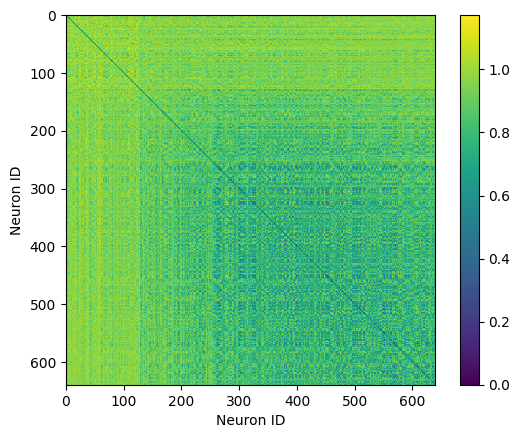

In [191]:
plt.imshow(neuron_dists)
plt.xlabel('Neuron ID')
plt.ylabel('Neuron ID')

plt.colorbar()

In [192]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0, metric='precomputed', init='random')
points = tsne.fit_transform(neuron_dists)
kmeans_labels = KMeans(n_clusters=4, random_state=0).fit(points)

/home/ntolley/anaconda3/envs/torch_test/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [193]:
layer_ids = np.repeat(np.arange(len(layer_size)), layer_size)
df_dict = {'TSNE1': points[:,0], 'TSNE2': points[:,1], 'layer': layer_ids, 'cluster': kmeans_labels.labels_}
df = pd.DataFrame(df_dict)

<Axes: xlabel='TSNE1', ylabel='TSNE2'>

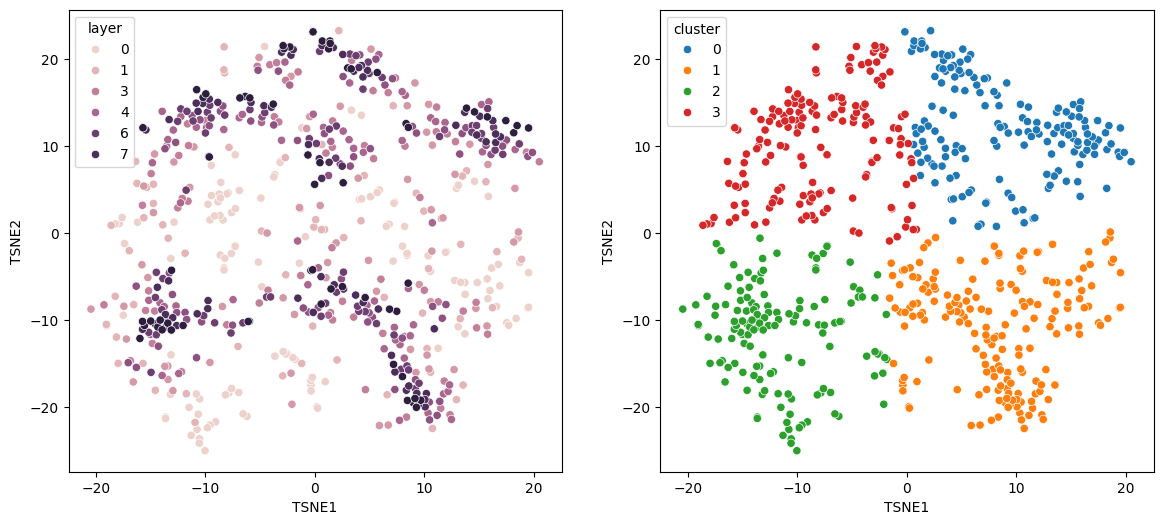

In [194]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='layer')

plt.subplot(1,2,2)
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='cluster', palette='tab10')

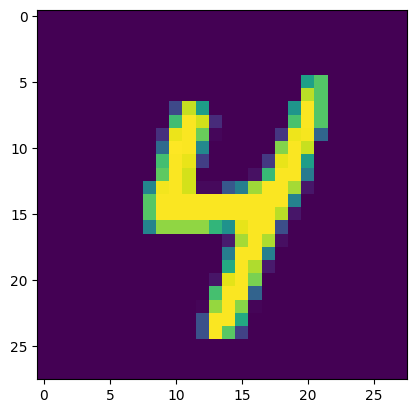

In [33]:
plt.imshow(images[3,0,:,:])

In [36]:
activations[2].size()

torch.Size([16, 64])